In [ ]:
from tensorflow.keras.models import load_model
from data import *
import os

In [ ]:
# for Gunpowder
ZARR_FOLDER = '../../../../data/cells/raw/zarr/'
gp_batch_size= 12
gp_voxel_shape = [1,1,1]
gp_input_shape= [256,256,4]
gp_output_shape = [256,256,4]

# For unet
OUTPUT_PATH = '../../../../data/cells/models/'
model_name = 'unet_cells.hdf5'
# unet_input_size = (256,256,4)
# unet_output_size = 4

### Load Model

In [ ]:
model_path = os.path.join(OUTPUT_PATH,model_name)

In [ ]:
model = load_model(model_path)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Block generation to prediction

In [6]:
def getBlocks(img_size, block_size):
    w = img_size[0] // block_size[0]
    h = img_size[1] // block_size[1]
    result = []
    print("We have {} - {} blocks ".format(w,h))
    for i in range(w):
        for j in range(h):
            x1 = i*block_size[0]
            y1 = j*block_size[1]
            x2 = x1+block_size[0]
            y2 = y1 + block_size[1]
            result.append([x1,y1,x2,y2])
    return result
    
blocks = getBlocks([1024,1024,4],[256,256,4])
blocks

We have 4 - 4 blocks 


[[0, 0, 256, 256],
 [0, 256, 256, 512],
 [0, 512, 256, 768],
 [0, 768, 256, 1024],
 [256, 0, 512, 256],
 [256, 256, 512, 512],
 [256, 512, 512, 768],
 [256, 768, 512, 1024],
 [512, 0, 768, 256],
 [512, 256, 768, 512],
 [512, 512, 768, 768],
 [512, 768, 768, 1024],
 [768, 0, 1024, 256],
 [768, 256, 1024, 512],
 [768, 512, 1024, 768],
 [768, 768, 1024, 1024]]

In [7]:
files = os.listdir(ZARR_FOLDER)
files = [os.path.join(ZARR_FOLDER,f) for f in files ]
files

['../../../../data/cells/raw/zarr/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.zarr',
 '../../../../data/cells/raw/zarr/ND8_DIV0+4h_20x_noConfinment_6_ch_4.zarr']

#### Append to data 'prediction' with the result of prediction assumbled

In [8]:
for f in files:
    print('processing {}'.format(f))
    batches = generate_test_batch(f,blocks)
    results = model.predict(np.array(batches['raw']))
    add_data(zarr_file= f,name= 'prediction',
             img_shape= (1024, 1024, 4),boxes_positions= blocks,data = results)

processing ../../../../data/cells/raw/zarr/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.zarr
Processing block [0, 0, 256, 256]
Processing block [0, 256, 256, 512]
Processing block [0, 512, 256, 768]
Processing block [0, 768, 256, 1024]
Processing block [256, 0, 512, 256]
Processing block [256, 256, 512, 512]
Processing block [256, 512, 512, 768]
Processing block [256, 768, 512, 1024]
Processing block [512, 0, 768, 256]
Processing block [512, 256, 768, 512]
Processing block [512, 512, 768, 768]
Processing block [512, 768, 768, 1024]
Processing block [768, 0, 1024, 256]
Processing block [768, 256, 1024, 512]
Processing block [768, 512, 1024, 768]
Processing block [768, 768, 1024, 1024]
processing ../../../../data/cells/raw/zarr/ND8_DIV0+4h_20x_noConfinment_6_ch_4.zarr
Processing block [0, 0, 256, 256]
Processing block [0, 256, 256, 512]
Processing block [0, 512, 256, 768]
Processing block [0, 768, 256, 1024]
Processing block [256, 0, 512, 256]
Processing block [256, 256, 512, 512]
P

### Test prediction

In [ ]:
fig=plt.figure(figsize=(10, 200))
columns = 2
rows = results.shape[0]
masks = np.array(batches['gt'])
for i in range(2):
    for j in range(4):

        pred = results[i][:,:,j]
        gt = masks[i][:,:,j]
        # img = im[i][:,:,j]
        # fig.add_subplot(rows*4, columns, i*j+j+1)
        # plt.imshow(img)
        fig.add_subplot(rows*4, columns, i*8+j*2+1)
        plt.imshow(pred)
        fig.add_subplot(rows*4, columns, i*8+j*2+2)
        plt.imshow(gt)
plt.show()

In [13]:
TEST_PATH = '../../../../data/cells/raw/zarr/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.zarr'
root = zarr.open(TEST_PATH, mode='r')
test = root['prediction'][:]

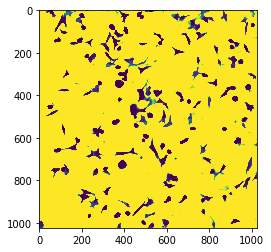

In [14]:
plt.imshow(test[:,:,0])

In [15]:
idx = test.argmax(axis=2)

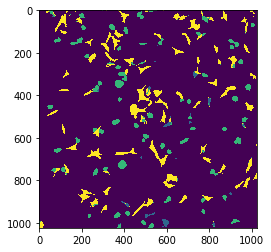

In [16]:
plt.imshow(idx)